# Bootstrap

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism-Bootstraped-Intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies and also allows you to calculate prediction intervals for all hierarchies. In this notebook we will see how to do it.

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute base forecast no coherent
from statsforecast.models import ETS, Naive
from statsforecast.core import StatsForecast

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533


The dataset can be grouped in the following non-strictly hierarchical structure.

In [ ]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

Using the `aggregate` function from `HierarchicalForecast` we can generate:
1. `Y_df`: the hierarchical structured series $\mathbf{y}_{[a,b]\tau}$
2. `S_df`: the aggregation constraings dataframe with $S_{[a,b]}$
3. `tags`: a list with the 'unique_ids' conforming each aggregation level.

In [ ]:
Y_df, S_df, tags = aggregate(df=Y_df, spec=spec)
Y_df = Y_df.reset_index()

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
Y_df.head()

,unique_id,ds,y
0,Australia,1998-01-01,23182.197269
1,Australia,1998-04-01,20323.380067
2,Australia,1998-07-01,19826.640511
3,Australia,1998-10-01,20830.129891
4,Australia,1999-01-01,22087.353380


In [ ]:
S_df.iloc[:5, :5]

,Australia/ACT/Canberra/Business,Australia/ACT/Canberra/Holiday,Australia/ACT/Canberra/Other,Australia/ACT/Canberra/Visiting,Australia/New South Wales/Blue Mountains/Business
Australia,1.0,1.0,1.0,1.0,1.0
Australia/ACT,1.0,1.0,1.0,1.0,0.0
Australia/New South Wales,0.0,0.0,0.0,0.0,1.0
Australia/Northern Territory,0.0,0.0,0.0,0.0,0.0
Australia/Queensland,0.0,0.0,0.0,0.0,0.0


In [ ]:
tags['Country/Purpose']

array(['Australia/Business', 'Australia/Holiday', 'Australia/Other',
       'Australia/Visiting'], dtype=object)

We can visualize the `S_df` dataframe and `Y_df` using the `HierarchicalPlot` class as follows.

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)

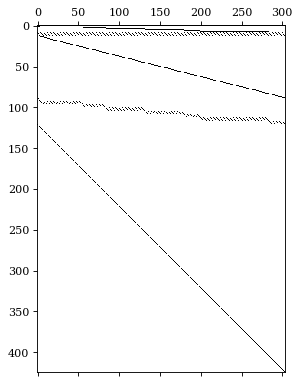

In [ ]:
hplot.plot_summing_matrix()

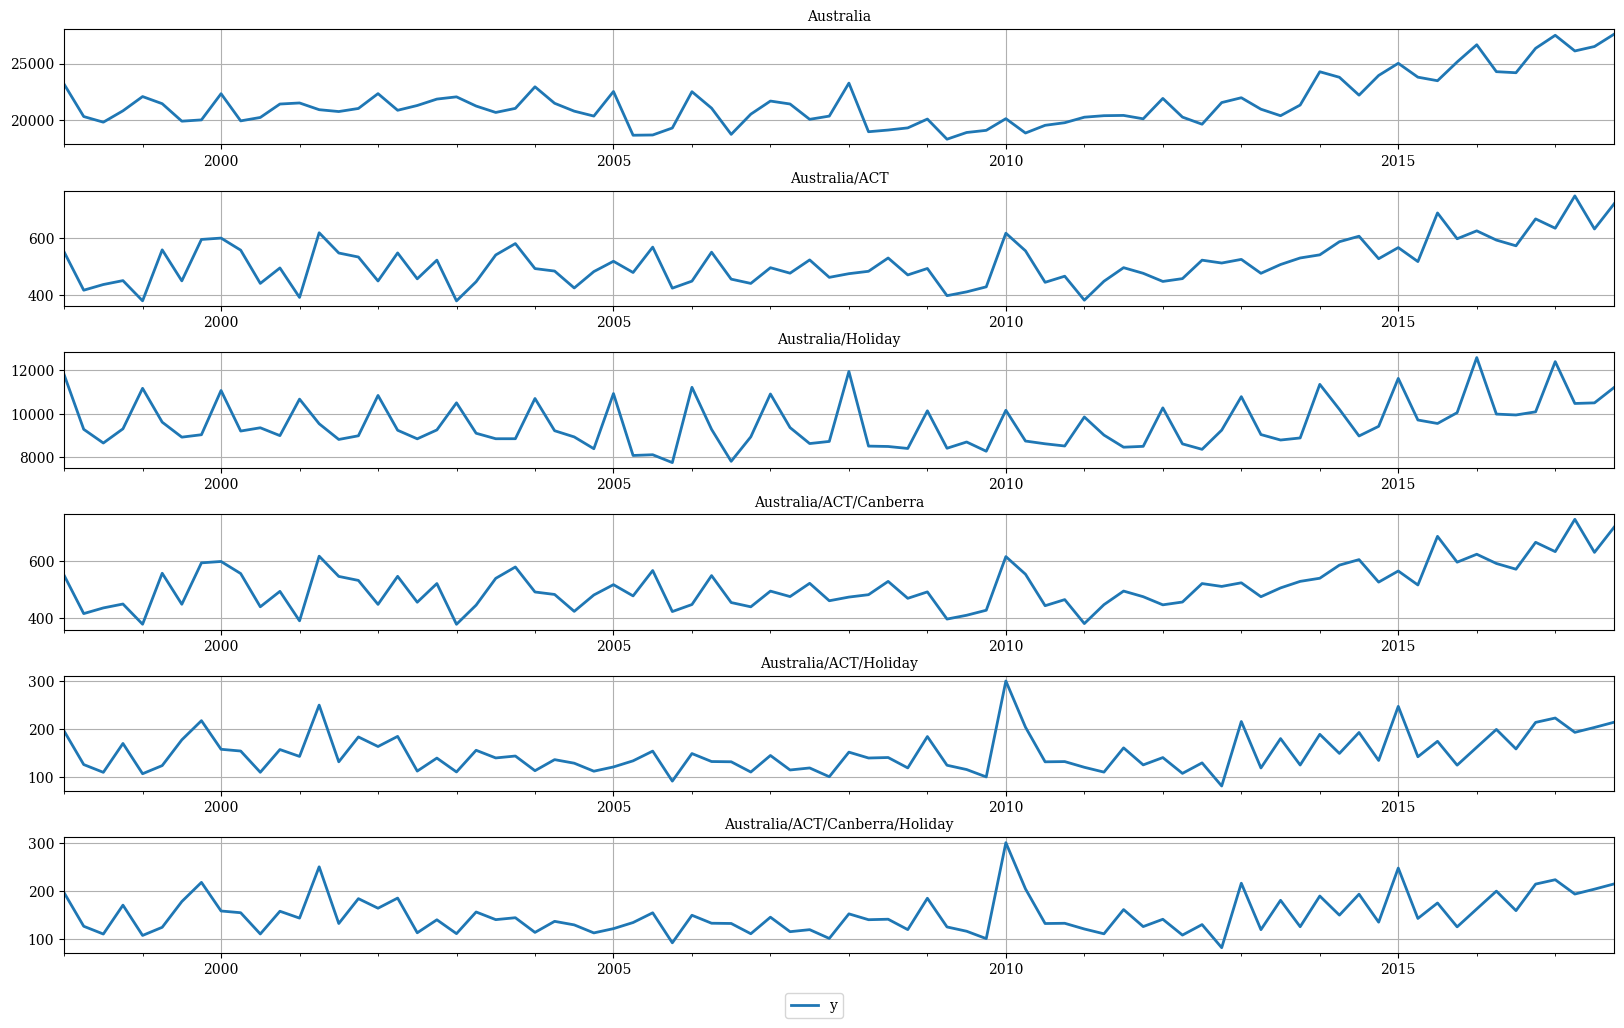

In [ ]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra/Holiday',
    Y_df=Y_df.set_index('unique_id')
)

### Split Train/Test sets

We use the final two years (8 quarters) as test set.

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

In [ ]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [ ]:
Y_train_df.groupby('unique_id').size()

unique_id
Australia                                                72
Australia/ACT                                            72
Australia/ACT/Business                                   72
Australia/ACT/Canberra                                   72
Australia/ACT/Canberra/Business                          72
                                                         ..
Australia/Western Australia/Experience Perth/Other       72
Australia/Western Australia/Experience Perth/Visiting    72
Australia/Western Australia/Holiday                      72
Australia/Western Australia/Other                        72
Australia/Western Australia/Visiting                     72
Length: 425, dtype: int64

## Computing Base Forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `AutoETS` and model. Observe that `Y_hat_df` contains the forecasts but they are not coherent. Since we are computing prediction intervals using bootstrapping, we only need the fitted values of the models.

In [ ]:
fcst = StatsForecast(df=Y_train_df, 
                     models=[ETS(season_length=4, model='ZAA')],
                     freq='QS', n_jobs=-1)
Y_hat_df = fcst.forecast(h=8, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/statsforecast/models.py:526: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


## Reconcile Base Forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`. If you want to calculate prediction intervals, you have to use the `level` argument as follows and set `intervals_method='bootstrap'`.

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, 
                          tags=tags, level=[80, 90], 
                          intervals_method='bootstrap')

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [ ]:
Y_rec_df.head()

,ds,ETS,ETS/BottomUp,ETS/BottomUp-lo-90,ETS/BottomUp-lo-80,ETS/BottomUp-hi-80,ETS/BottomUp-hi-90,ETS/MinTrace_method-mint_shrink,ETS/MinTrace_method-mint_shrink-lo-90,ETS/MinTrace_method-mint_shrink-lo-80,ETS/MinTrace_method-mint_shrink-hi-80,ETS/MinTrace_method-mint_shrink-hi-90,ETS/MinTrace_method-ols,ETS/MinTrace_method-ols-lo-90,ETS/MinTrace_method-ols-lo-80,ETS/MinTrace_method-ols-hi-80,ETS/MinTrace_method-ols-hi-90
unique_id,,,,,,,,,,,,,,,,,
Australia,2016-01-01,26080.878906,24487.349609,23244.120801,23333.696875,25381.792969,25426.333984,25532.523559,24428.911701,24709.210638,26365.606934,26476.255501,26034.114241,24914.136375,25100.462938,27102.735022,27176.416922
Australia,2016-04-01,24587.011719,23069.744141,21826.519336,21912.962891,23946.609766,24281.443359,24118.557177,23199.968626,23295.244252,25108.470410,25489.383606,24567.460995,23484.050568,23640.638423,25709.763678,25809.249492
Australia,2016-07-01,24147.308594,22689.777344,21297.134766,21530.438281,23701.177734,24155.816406,23731.251387,22627.639669,22818.729182,24821.488458,25246.867432,24150.134898,23030.156834,23155.025556,25359.992376,25404.841402
Australia,2016-10-01,24794.041016,23429.757812,22037.121094,22276.457031,24241.419922,24441.160156,24486.549344,23385.927232,23600.704525,25353.555625,25481.478557,24831.584516,23725.924464,23836.475174,25900.205254,25977.265089
Australia,2017-01-01,26284.000000,24940.042969,23696.719141,23904.384766,25814.945312,25974.169824,26041.867488,24972.077858,25158.986710,26918.104747,27135.580845,26348.203335,25254.659324,25487.502291,27410.873035,27477.334507


## Plot Predictions

Then we can plot the probabilist forecasts using the following function.

In [ ]:
plot_df = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_df.set_index('ds', append=True)], axis=1)
plot_df = plot_df.reset_index('ds')

### Plot single time series

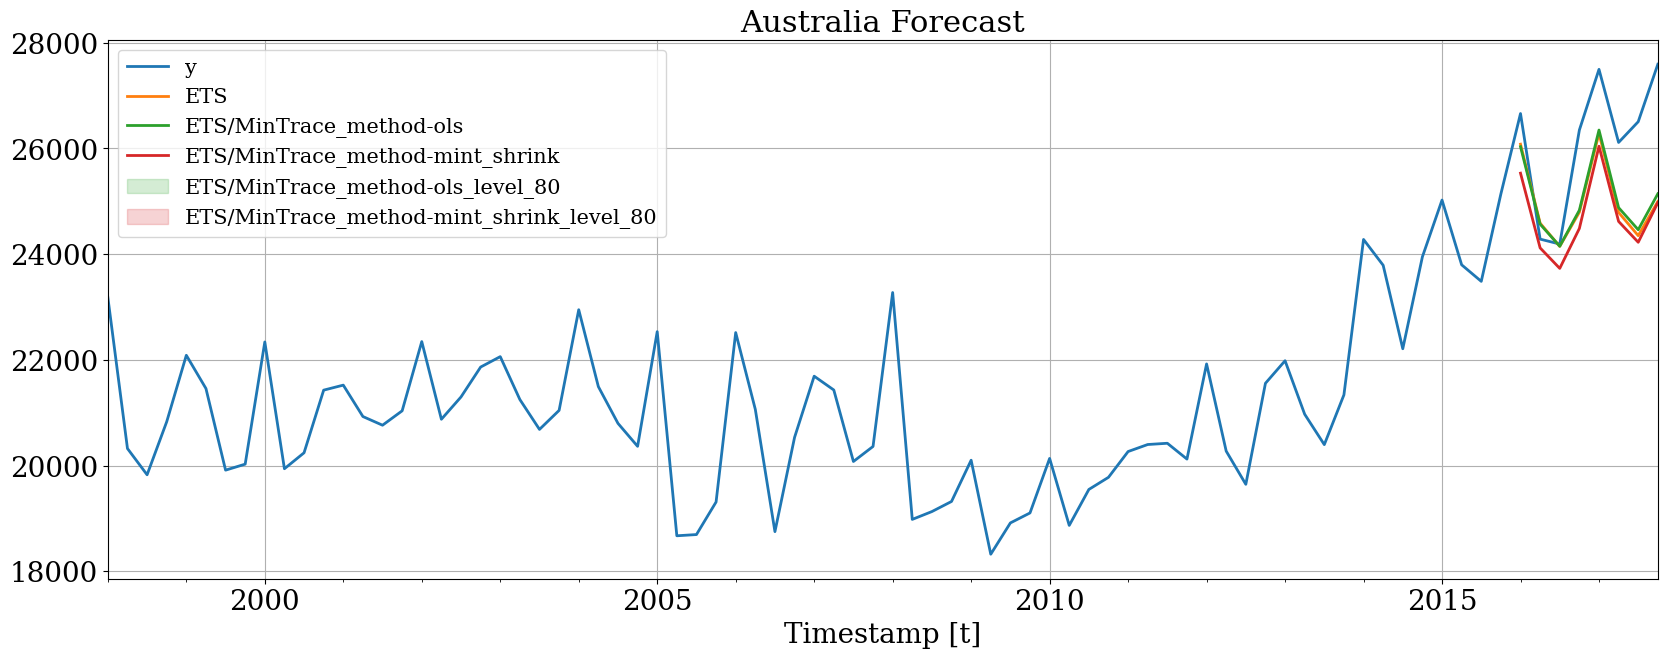

In [ ]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'ETS', 'ETS/MinTrace_method-ols', 'ETS/MinTrace_method-mint_shrink'],
    level=[80]
)

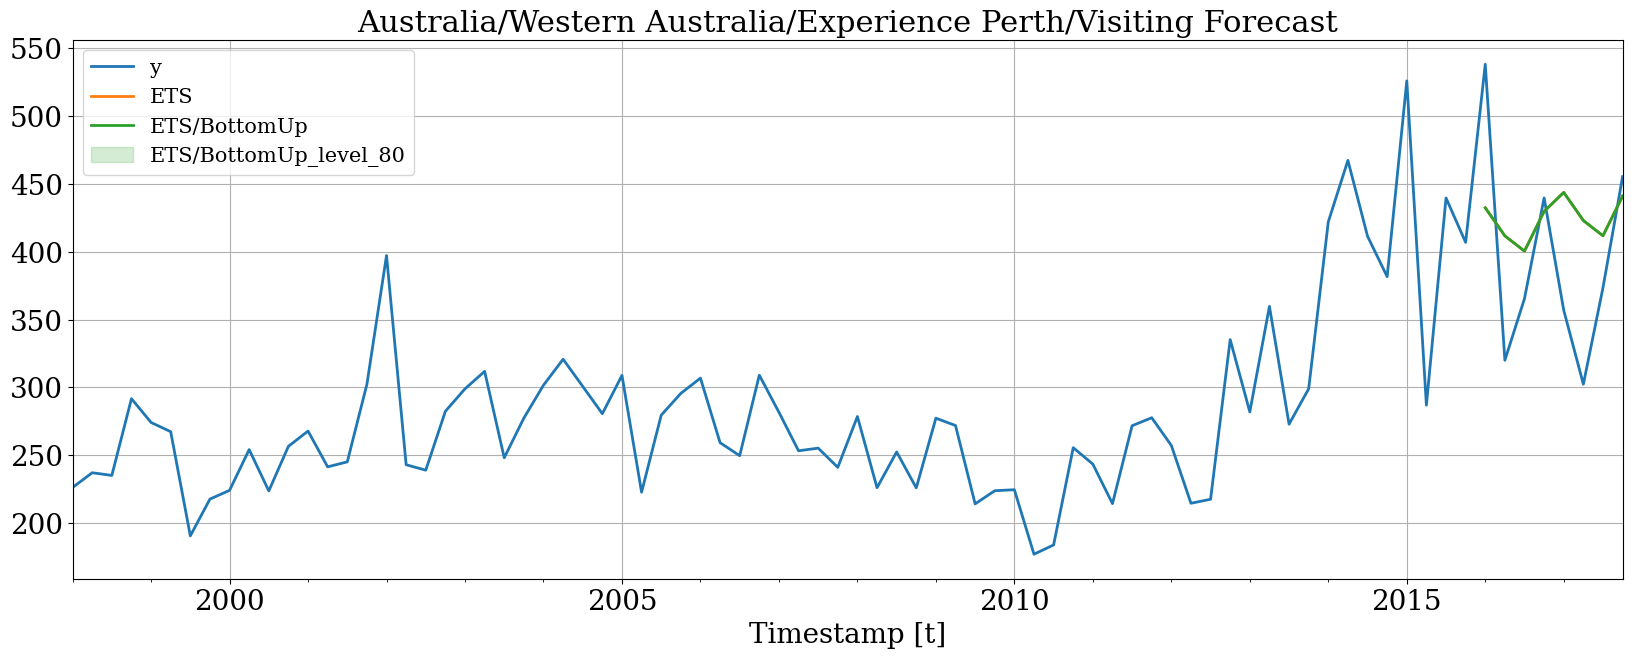

In [ ]:
# Since we are plotting a bottom time series
# the probabilistic and mean forecasts
# differ due to bootstrapping
hplot.plot_series(
    series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'ETS', 'ETS/BottomUp'],
    level=[80]
)

### Plot hierarchichally linked time series

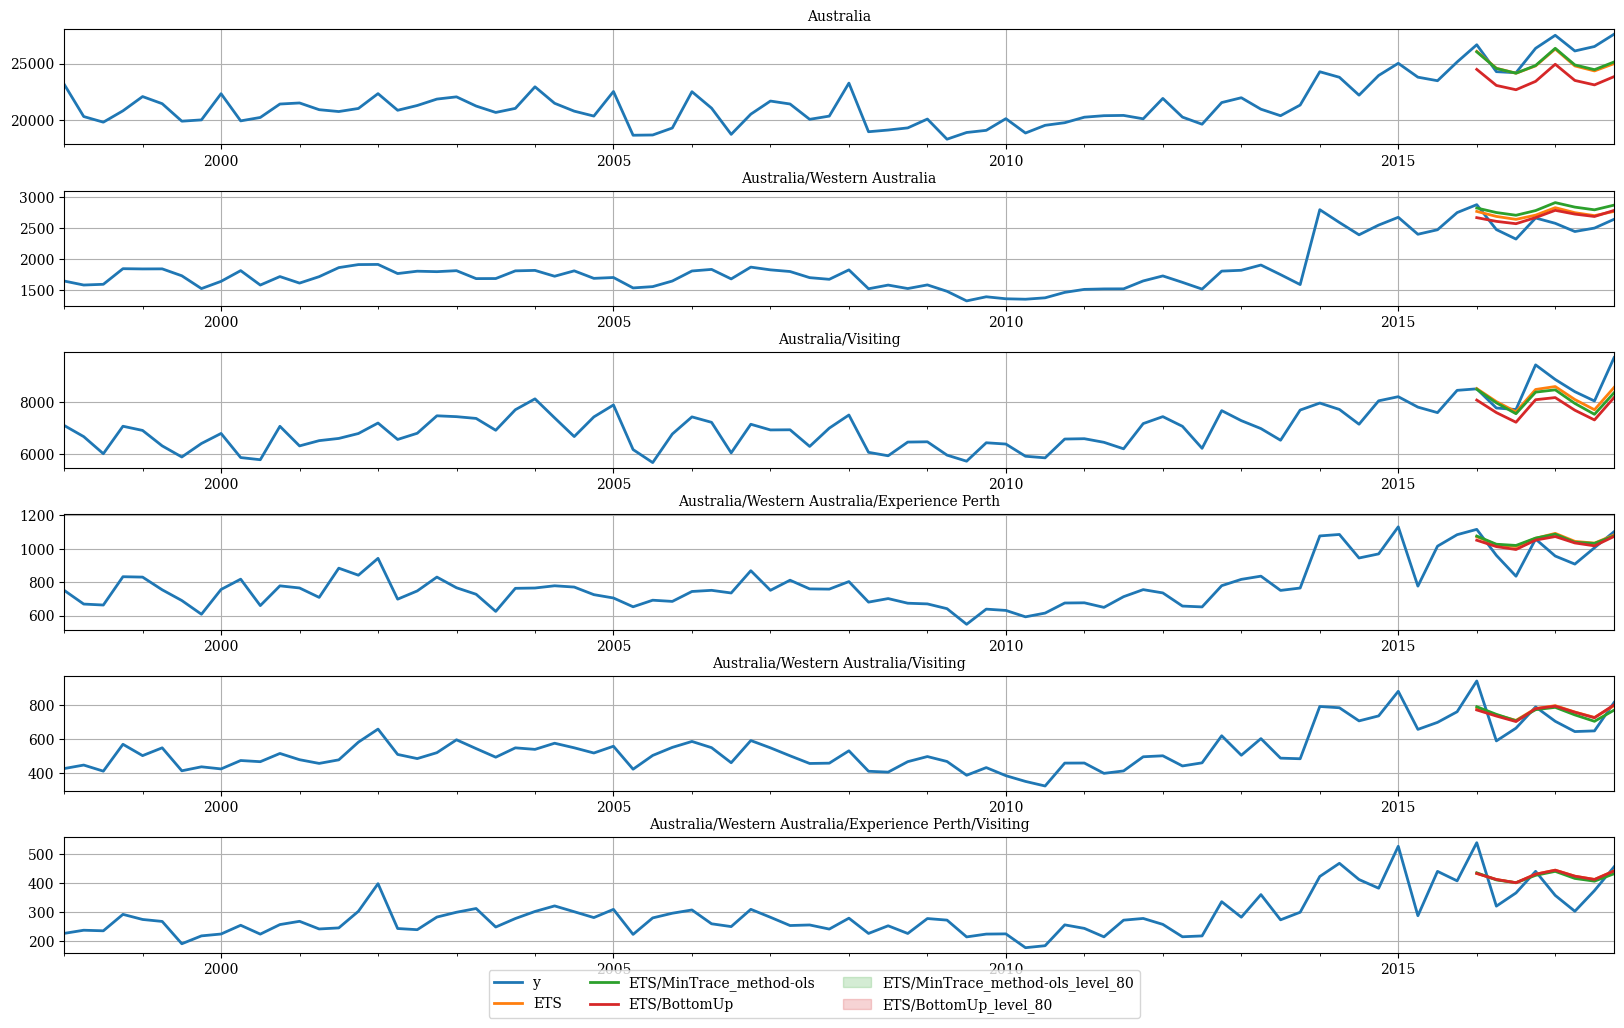

In [ ]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'ETS', 'ETS/MinTrace_method-ols', 'ETS/BottomUp'],
    level=[80]
)

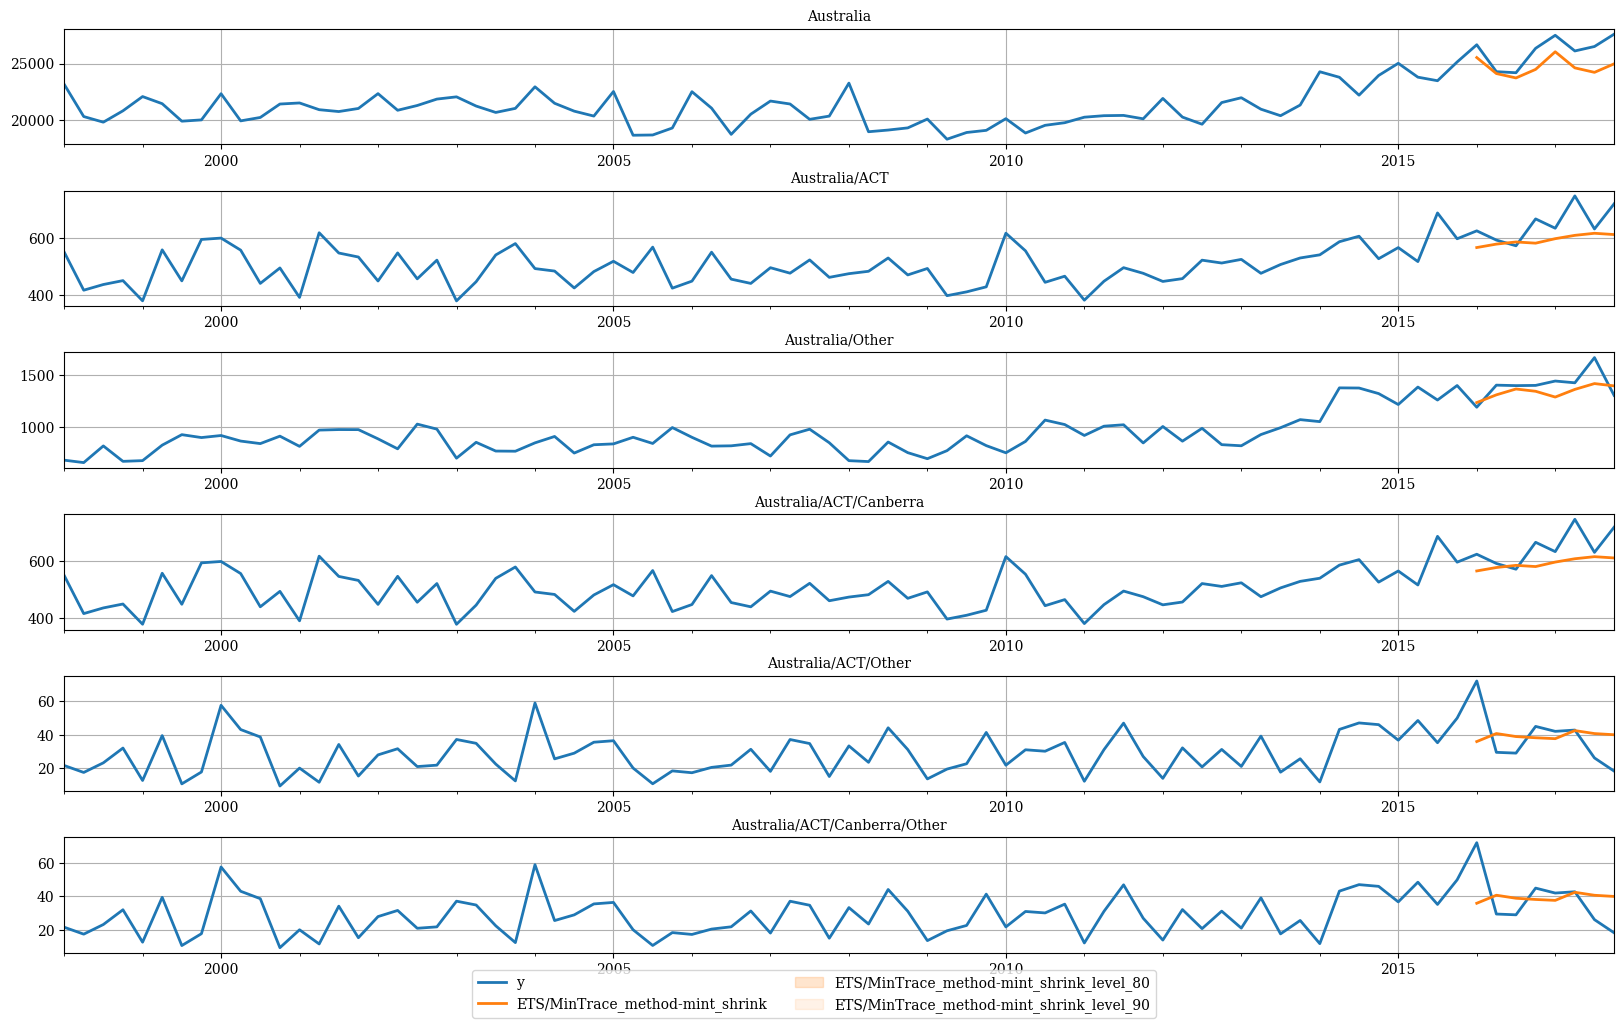

In [ ]:
# ACT only has Canberra
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra/Other',
    Y_df=plot_df, 
    models=['y', 'ETS/MinTrace_method-mint_shrink'],
    level=[80, 90]
)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Shanika L. Wickramasuriya, George Athanasopoulos, and Rob J. Hyndman. Optimal forecast reconciliation for hierarchical and grouped time series through trace minimization.Journal of the American Statistical Association, 114(526):804–819, 2019. doi: 10.1080/01621459.2018.1448825. URL https://robjhyndman.com/publications/mint/.](https://robjhyndman.com/publications/mint/)
- [Puwasala Gamakumara Ph. D. dissertation. Monash University, Econometrics and Business Statistics (2020). "Probabilistic Forecast Reconciliation"](https://bridges.monash.edu/articles/thesis/Probabilistic_Forecast_Reconciliation_Theory_and_Applications/11869533)